# Bax Pore Assembly
A version of BAX pore assembly where the subunits dimerize and then
tetramerize instead of assembling sequentially (contrast with
bax_pore_sequential.py). Inhibition of pore formation by Mcl-1 is also
implemented.

In [2]:
from pysb import *

Model()

# Each BAX-BAX bond must always involve a t1 site on one monomer and a
# t2 site on the other.
Monomer('BAX', ['t1', 't2', 'inh'])
Annotation(BAX, 'http://identifiers.org/uniprot/Q07812')
Monomer('MCL1', ['b'])
Annotation(MCL1, 'http://identifiers.org/uniprot/Q07820')

# Two lone monomers form a dimer.
Parameter('kdimf', 1e-6)
Parameter('kdimr', 1e-7)
Rule('bax_dim',
     BAX(t1=None, t2=None) + BAX(t1=None, t2=None) |
     BAX(t1=1, t2=None) % BAX(t1=None, t2=1),
     kdimf, kdimr)

# Two lone dimers form a tetramer, with a higher rate than the dimerization.
Parameter('ktetf', 1e-3)
Parameter('ktetr', 1e-4)
Rule('bax_tet',
     BAX(t1=1, t2=None) % BAX(t1=None, t2=1) + BAX(t1=2, t2=None) % BAX(t1=None, t2=2) |
     BAX(t1=1, t2=3) % BAX(t1=4, t2=1) % BAX(t1=2, t2=4) % BAX(t1=3, t2=2),
     ktetf, ktetr)

# An inhibitory protein can bind to a BAX subunit at any time.
Parameter('kbaxmcl1f', 1e-5)
Parameter('kbaxmcl1r', 1e-6)
Rule('bax_inh_mcl1',
     BAX(inh=None) + MCL1(b=None) |
     BAX(inh=1)    % MCL1(b=1),
     kbaxmcl1f, kbaxmcl1r)

# Initial conditions
Parameter('BAX_0', 8e4)
Initial(BAX(t1=None, t2=None, inh=None), BAX_0)
Parameter('MCL1_0', 2e4)
Initial(MCL1(b=None), MCL1_0)
for p in BAX_0, MCL1_0:
    Annotation(p, 'http://identifiers.org/doi/10.1371/journal.pcbi.1002482',
               'isDescribedBy')

# We must fully specify all four BAX-BAX bonds, otherwise the pattern
# is too loose, match a given species multiple times (beyond the
# factor of four expected due to the rotational symmetry of the
# tetramer), resulting in erroneously high values.
Observable('BAX4', BAX(t1=1, t2=3) % BAX(t1=4, t2=1) % BAX(t1=2, t2=4) % BAX(t1=3, t2=2))
# Same all-bonds requirement here.  However since the BAX tetramer is
# considered inhibited when even one subunit has an inhibitor bound,
# we only need to explicitly write inh=ANY on one of the monomer
# patterns.
Observable('BAX4_inh', BAX(inh=ANY, t1=1, t2=3) % BAX(t1=4, t2=1) % BAX(t1=2, t2=4) % BAX(t1=3, t2=2))

Observable('BAX4_inh', BAX(t1=1, t2=3, inh=<class 'pysb.core.ANY'>) % BAX(t1=4, t2=1) % BAX(t1=2, t2=4) % BAX(t1=3, t2=2))

## Simulation

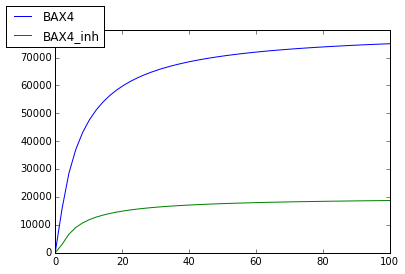

In [5]:
%matplotlib inline
from pylab import *
from pysb.integrate import odesolve

t = linspace(0, 100)
x = odesolve(model, t)

p = plot(t, c_[x['BAX4'], x['BAX4_inh']])
figlegend(p, ['BAX4', 'BAX4_inh'], 'upper left')
show()